# Project 6  - Create a counterfeit banknote detection algorithm based on Logistic Regression

## Get started

In [131]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import seaborn as sns

%matplotlib inline

In [9]:
df = pd.read_csv(Path.cwd()/'notes.csv')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


The dataset is labelled and contains the following information:
- The length of the ticket (in mm);
- The height of the ticket (measured on the left side, in mm);
- The height of the ticket (measured on the right side, in mm);
- The margin between the top edge of the banknote and the image thereof (in mm);
- The margin between the lower edge of the banknote and the image thereof (in mm);
- The diagonal of the banknote (in mm).
- label column type boolean 

## Data Description

Let's start by having a look on the structure of the dataset and the global quality.

In [10]:
df.shape

(170, 7)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [12]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [13]:
df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

<div class='info info-block info-alert'>

Nothing looks odd: none missing values, none extremes or atypical values. The data format is good.    

## Univariate Analysis

### Distribution

In [81]:
tmp = df.iloc[:,1:] # we remove the boolean column for the distribution

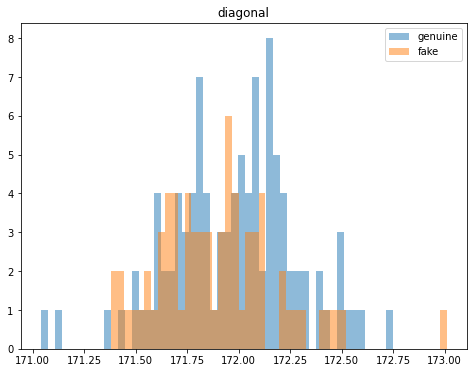

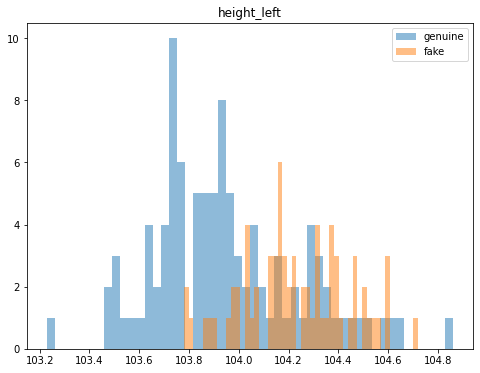

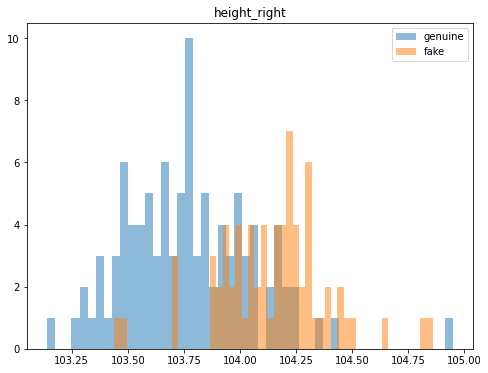

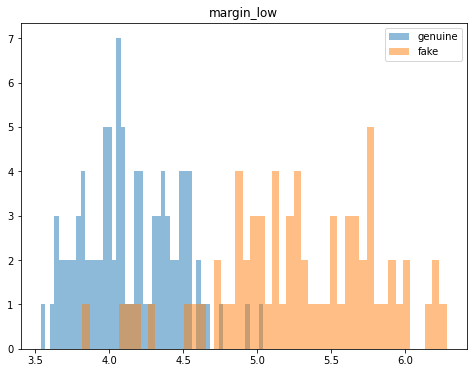

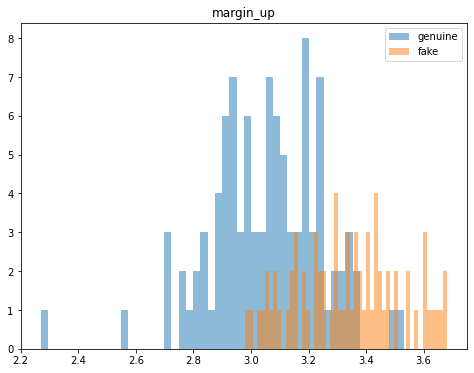

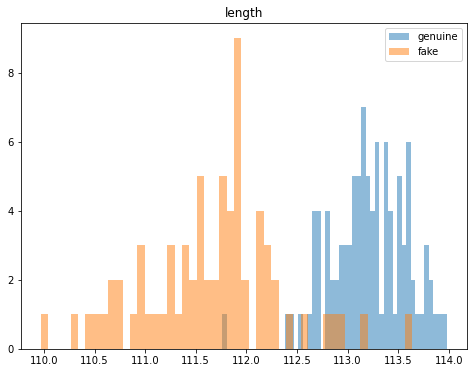

In [16]:
# Check the Distribution for each columns
for i in tmp.columns:
    plt.figure(figsize=(8,6))
    tmp1 = df[df['is_genuine'] == True]
    tmp2 = df[df['is_genuine'] == False]
    plt.hist(tmp1[i], bins=50, alpha=0.5, label="genuine")
    plt.hist(tmp2[i], bins=50, alpha=0.5, label="fake")
    plt.title(i)
    plt.legend(loc='upper right')

  
- We can see that the distributions for each variables look slightly different, whether or not, the note is genuine. In particular, for length, margin up/low and height. This observation is not that strong for diagonal. Perhaps, we will drop this variable later depending on the results of the ACP.

    This is interesting for our case, as we want to use these variables to classify the notes in 2 groups: genuine / fake. 
    
- All in all, each variables seem to be normally distribute. However, some of them (fx. diagonal) are skewed most likely due to extreme values. Let's use boxplots to see whether or not these values can be considered as outliers.

### Box-plot

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


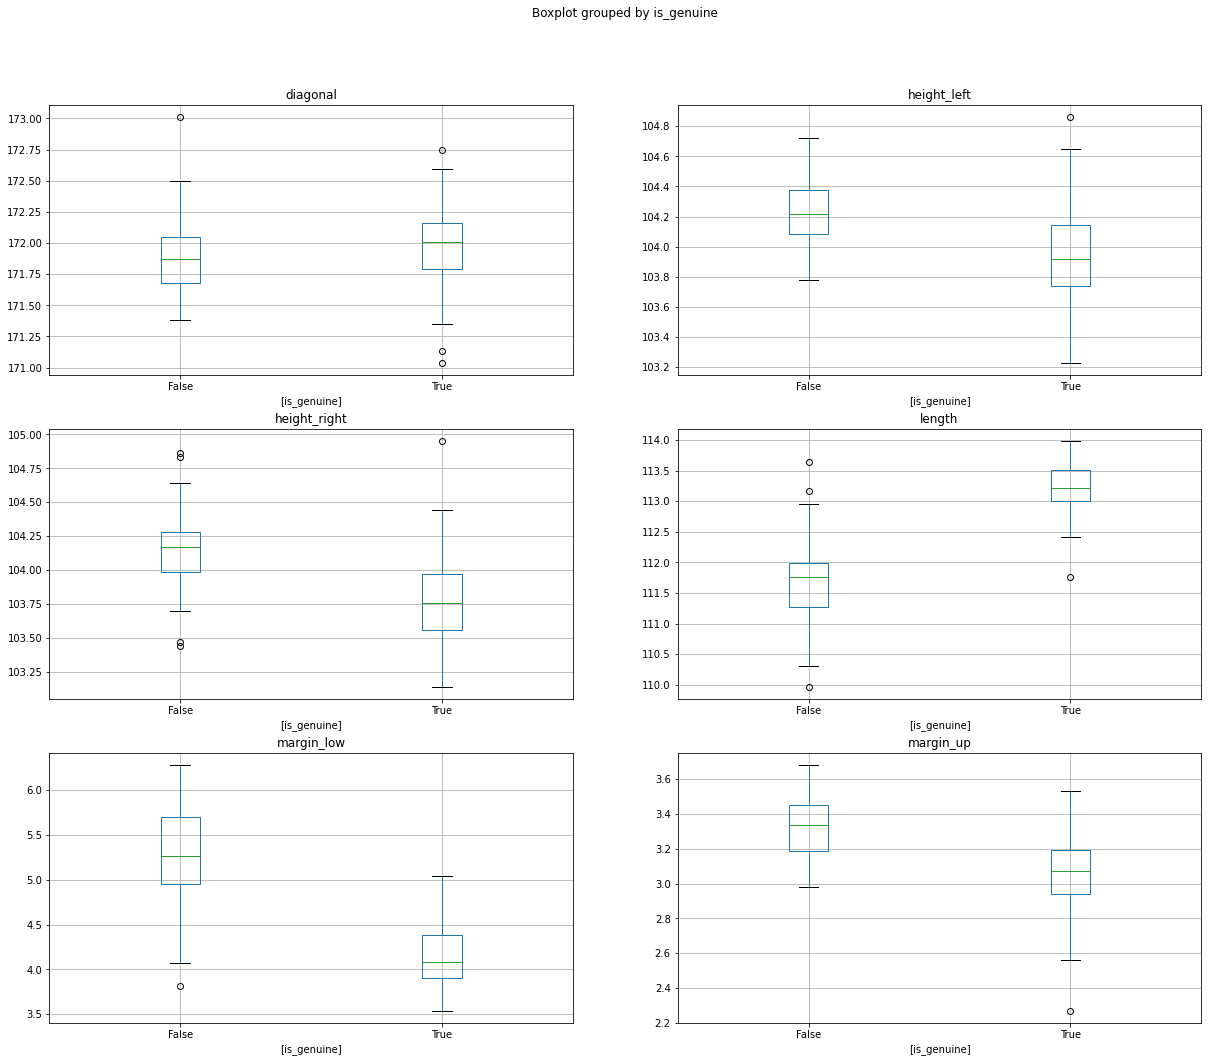

In [17]:
fig, ax_new = plt.subplots(3,2, sharey=False,figsize=(20,17))
df.boxplot(by="is_genuine",ax=ax_new)
plt.show()

We can detect various outliers (extreme values) from the box plots. 
If we keep them in the dataset, it might make the detector less sensitive or accurate to detect whether or not a banknote is fake.

We can check their values with the function matplotlib.cbook.boxplot_stats.
The function is documented here: https://matplotlib.org/api/cbook_api.html

In [94]:
tmp1 = df[df['is_genuine'] == False]
tmp2 = df[df['is_genuine'] == True]

In [96]:
print(boxplot_stats(tmp1.margin_low).pop(0)['fliers'], boxplot_stats(tmp2.margin_low).pop(0)['fliers'])

[3.82] []


In [97]:
print(boxplot_stats(tmp1.height_right).pop(0)['fliers'],boxplot_stats(tmp2.height_right).pop(0)['fliers'])

[103.47 103.44 104.83 104.86] [104.95]


In [101]:
print(boxplot_stats(tmp1.height_left).pop(0)['fliers'],boxplot_stats(tmp2.height_left).pop(0)['fliers'])

[] [104.86]


In [98]:
print(boxplot_stats(tmp1.diagonal).pop(0)['fliers'],boxplot_stats(tmp2.diagonal).pop(0)['fliers'])

[173.01] [171.13 171.04 172.75]


In [99]:
print(boxplot_stats(tmp1.length).pop(0)['fliers'],boxplot_stats(tmp2.length).pop(0)['fliers'])

[109.97 113.64 113.17] [111.76]


In [100]:
print(boxplot_stats(tmp1.margin_up).pop(0)['fliers'],boxplot_stats(tmp2.margin_up).pop(0)['fliers'])

[] [2.27]


At maximun there are 4 outliers per columns which is very few on 170 rows (2%). For that reason, and to create the most accurate detector possible, we decide to drop these extreme values from the dataset. 

For that purpose, we can for example use the IQR scores and the following rule of thumb: anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed. 

Others techniques to manage outliers involved for example log transformations, replacing by median values (and not the mean, which is affected by the outliers).

In [104]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    return df_out

In [143]:
df2 = df.groupby('is_genuine').apply(remove_outliers).reset_index(drop=True)

In [127]:
df2

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,False,171.45,104.03,104.26,4.88,3.44,111.92
1,False,171.97,104.38,104.18,5.59,3.47,110.98
2,False,171.94,104.21,104.10,4.28,3.47,112.23
3,False,172.04,104.34,104.48,4.88,3.28,112.15
4,False,171.75,104.16,104.23,5.75,3.25,111.68
...,...,...,...,...,...,...,...
150,True,172.49,103.92,103.91,4.42,2.84,113.38
151,True,172.00,104.32,104.26,4.53,3.04,112.93
152,True,171.49,103.77,103.60,4.01,3.09,112.95
153,True,172.10,103.98,103.86,4.47,3.06,113.00


/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


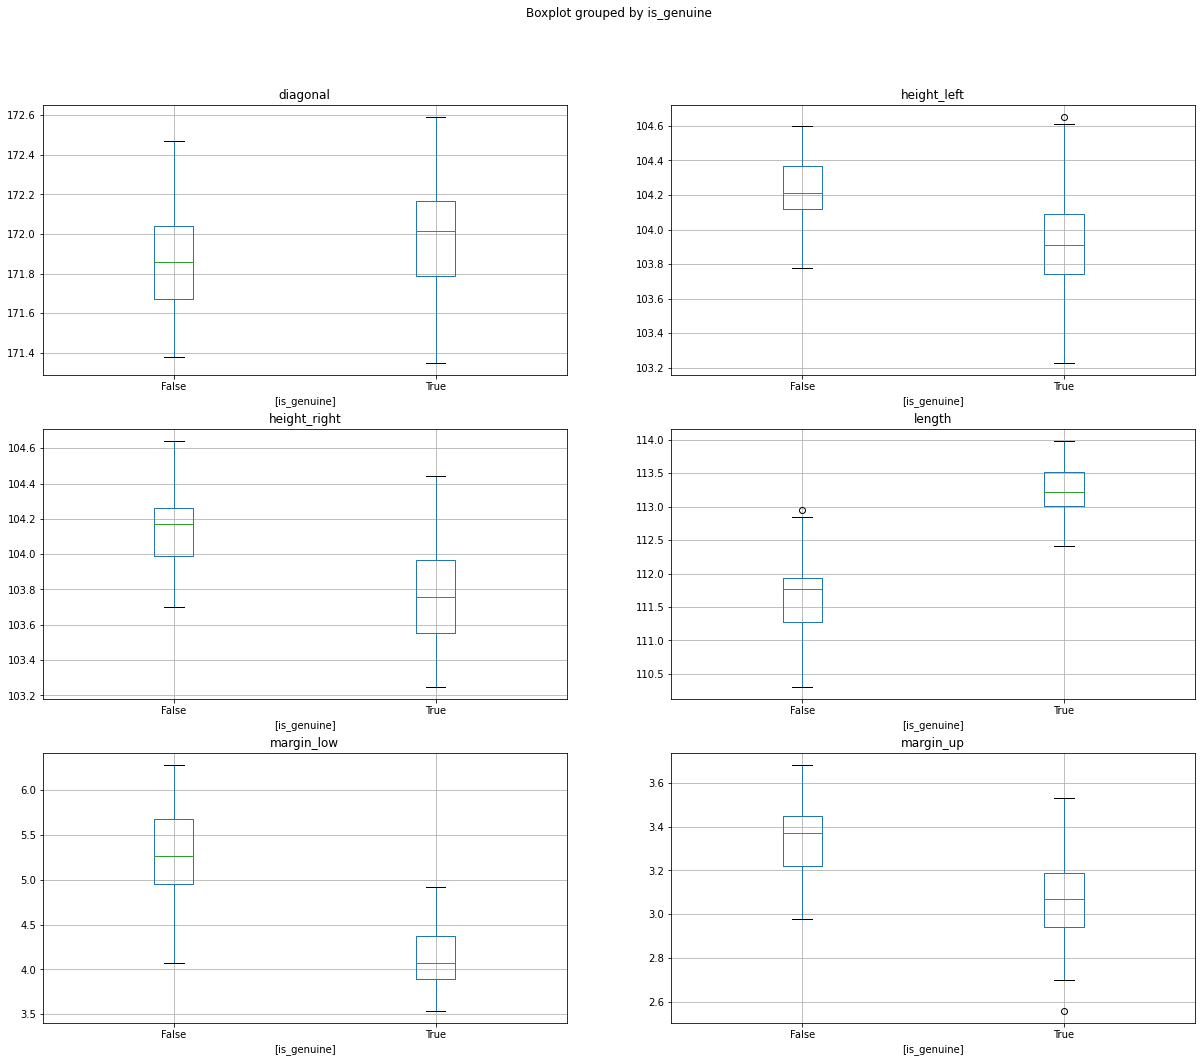

In [128]:
# Let's check the results
fig, ax_new = plt.subplots(3,2, sharey=False,figsize=(20,17))
df2.boxplot(by="is_genuine",ax=ax_new)
plt.show()

We can see that the function worked well at removing the main outliers. Some outliers are remaining as they are very close to the Q3. We keep them.

## Bivariate Analysis

In the previous part, we visualized the structure and distribution within a single column. 
In this part, we'll expand the exploration by visualizing the relationships between two variables at a time to understand:
- How variables interact with one another?
- Does an increase in one variable correlate with an increase/decrease in another? 

In [144]:
# Drop the boolean column from the analysis
tmp = df2.iloc[:,1:] 

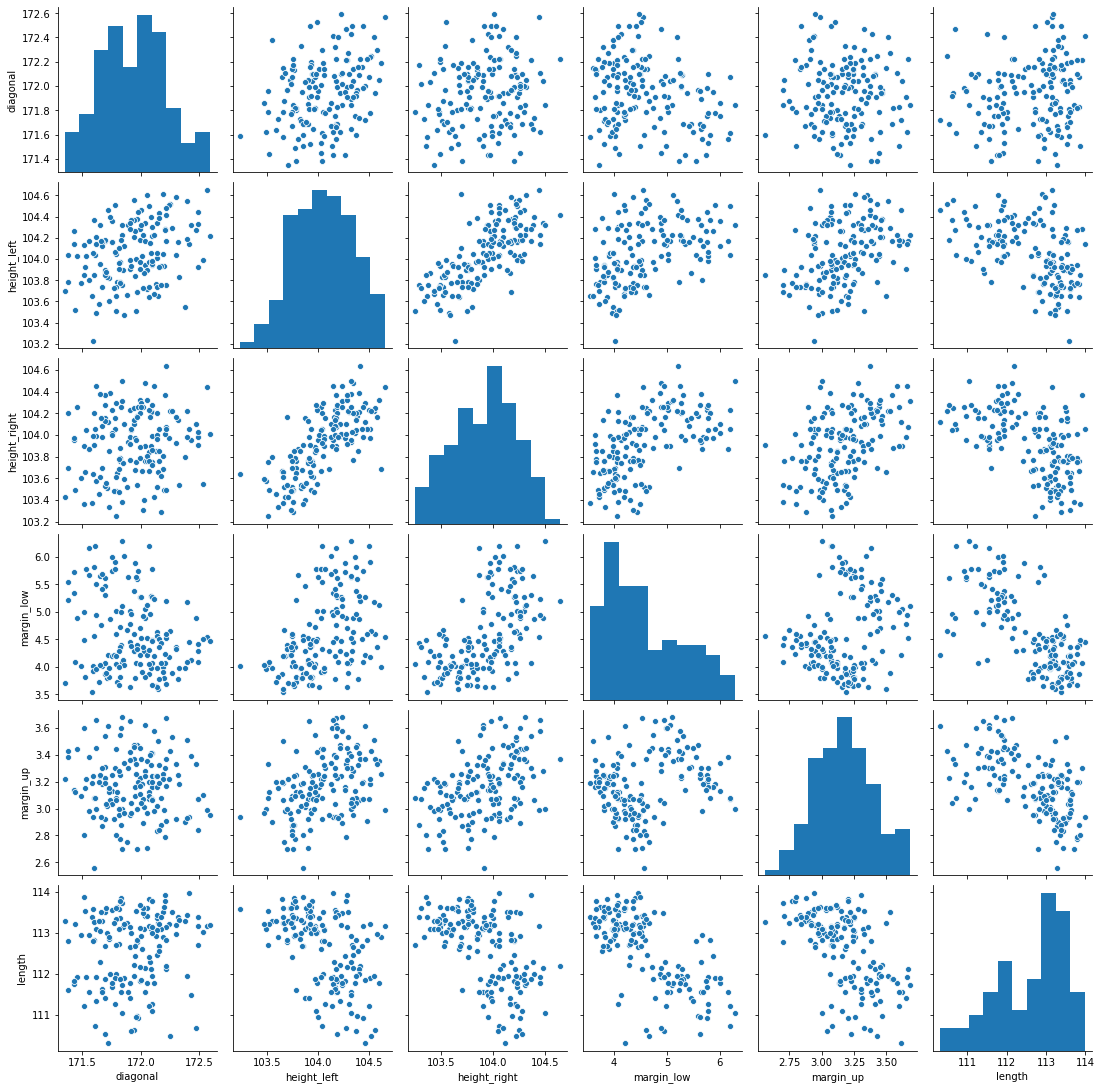

In [145]:
sns.pairplot(tmp)

Observations:

    - height_left & height_right seem to be positively correlated with margin_up, margin_low and to each other, and negatively correlated to length.
    
    - margin_low & margin_up seem to be negatively correlated to length and positively with height (left and right)
    
These observations are relevant and might be visible likewise with the PCA.